# Data Preprocessing

In [76]:
# @title Imports
import numpy as np
import math
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import sklearn as sk
from sklearn import linear_model
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [77]:
# @title Load in Data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
properties_train = pd.read_csv('./data/properties_2016.csv')
properties_test = pd.read_csv('./data/properties_2017.csv')
demographics_data = pd.read_csv('./data/demographics.csv')

## Can run all below this without reloading big data set

In [78]:
# @title Merge log error
traindf = pd.merge(properties_train, train, on='parcelid') # merges log error, transactiondate with parcelid
testdf = pd.merge(properties_test, test, on='parcelid')

In [79]:
# @title Helper function for manipulating census tract
# rawcensustractandblock
def format_numbers(x):
    if x == int(x):
        return math.trunc(float('{:.0f}'.format(x * 100)))
    else:
        return math.trunc(float('{:.2f}'.format(x * 100).rstrip('.')))

In [80]:
# @title Preprocessing Helper Function
def preprocessing(traindf):
    traindf = traindf[traindf['rawcensustractandblock'].notna()]
    traindf.drop("fips", axis = 1, inplace = True)
    traindf.drop("latitude", axis = 1, inplace = True)
    traindf.drop("longitude", axis = 1, inplace = True)
    traindf.drop("censustractandblock", axis = 1, inplace = True)
    traindf.drop('propertycountylandusecode', axis = 1, inplace = True)

    # dropping ones with too little
    traindf.drop('finishedsquarefeet13', axis = 1, inplace = True) # only 54 non-null for perimeter
    traindf.drop('finishedsquarefeet15', axis = 1, inplace = True) # only 5664 non-null for total area
    traindf.drop('finishedfloor1squarefeet', axis = 1, inplace = True) # only 10985 non-null for size of finished living area 1st floor
    traindf.drop('finishedsquarefeet50', axis = 1, inplace = True) # only 10985 non-null for finished living area on first floor
    traindf.drop('finishedsquarefeet6', axis = 1, inplace = True) # only 712 non-null for base unfinished and finished area
    traindf.drop('architecturalstyletypeid', axis = 1, inplace = True) # only 405 non-null
    traindf.drop('buildingclasstypeid', axis = 1, inplace = True) # all null

    traindf = traindf.dropna(subset=['calculatedfinishedsquarefeet']) # 142845 entries compared to 142396 non-null for calculated
    traindf = traindf.dropna(subset=['finishedsquarefeet12']) # 135966 non-null entries here compared to total 142396, can thin down

    # formatting for censustract data
    traindf['rawcensustractandblock'] = traindf['rawcensustractandblock'].apply(format_numbers)
    traindf = traindf.rename(columns={'rawcensustractandblock': 'censustractandblock'})

    # fill categorical data first
    # airconditioning type Na means None so 5
    traindf['airconditioningtypeid'] = traindf['airconditioningtypeid'].fillna(5)
    traindf['airconditioningtypeid'] = traindf['airconditioningtypeid'].astype('category')

    # buildingqualitytypeid (fill with average)
    traindf['buildingqualitytypeid'] = traindf['buildingqualitytypeid'].fillna(4)
    traindf['buildingqualitytypeid'] = traindf['buildingqualitytypeid'].astype('category')

    # decktypeid (0 means no deck)
    traindf['decktypeid'] = traindf['decktypeid'].fillna(0)
    traindf['decktypeid'] = traindf['decktypeid'].astype('category')

    # hashottuborspa (0 means none)
    traindf['hashottuborspa'] = traindf['hashottuborspa'].fillna(0)
    traindf['hashottuborspa'] = traindf['hashottuborspa'].astype('category')

    # heatingorsystemtypeid (13 means None)
    traindf['heatingorsystemtypeid'] = traindf['heatingorsystemtypeid'].fillna(13)
    traindf['heatingorsystemtypeid'] = traindf['heatingorsystemtypeid'].astype('category')

    # propertylandusetypeid
    traindf['propertylandusetypeid'] = traindf["propertylandusetypeid"].fillna(traindf['propertylandusetypeid'].median())
    traindf['propertylandusetypeid'] = traindf['propertylandusetypeid'].astype('category')

    # propertyzoningdesc
    traindf['propertyzoningdesc'] = traindf['propertyzoningdesc'].fillna('None')
    traindf['propertyzoningdesc'] = traindf['propertyzoningdesc'].astype('category')

    # regionidcity
    traindf['regionidcity'] = traindf['regionidcity'].fillna('None')
    traindf['regionidcity'] = traindf['regionidcity'].astype('category')

    # regionidcounty
    traindf['regionidcounty'] = traindf['regionidcounty'].fillna('None')
    traindf['regionidcounty'] = traindf['regionidcounty'].astype('category')

    # regionidneighborhood
    traindf['regionidneighborhood'] = traindf['regionidneighborhood'].fillna('None')
    traindf['regionidneighborhood'] = traindf['regionidneighborhood'].astype('category')

    # regionidzip
    traindf['regionidzip'] = traindf['regionidzip'].fillna('None')
    traindf['regionidzip'] = traindf['regionidzip'].astype('category')

    # storytypeid
    traindf['storytypeid'] = traindf['storytypeid'].fillna(traindf['storytypeid'].median())
    traindf['storytypeid'] = traindf['storytypeid'].astype('category')

    # typeconstructiontypeid
    traindf['typeconstructiontypeid'] = traindf['typeconstructiontypeid'].fillna(traindf['typeconstructiontypeid'].median())
    traindf['typeconstructiontypeid'] = traindf['typeconstructiontypeid'].astype('category')

    # unitcnt (default 1)
    traindf['unitcnt'] = traindf['unitcnt'].fillna(1)

    # yardbuildingsqft17 (patio default 0)
    traindf['yardbuildingsqft17'] = traindf['yardbuildingsqft17'].fillna(0)

    # yardbuildingsqft26 (storage default 0)
    traindf['yardbuildingsqft26'] = traindf['yardbuildingsqft26'].fillna(0)

    # yearbuilt (default unsure)
    traindf['yearbuilt'] = traindf['yearbuilt'].fillna("")
    traindf['yearbuilt'] = traindf['yearbuilt'].astype('category')

    # numberofstories (default 1)
    traindf['numberofstories'] = traindf['numberofstories'].fillna(1)

    # taxdelinquencyyear (fill with None)
    traindf['taxdelinquencyyear'] = traindf['taxdelinquencyyear'].fillna("None")
    traindf['taxdelinquencyyear'] = traindf['taxdelinquencyyear'].astype('category')

    # taxdelinquencyflag (fill with N)
    traindf['taxdelinquencyflag'] = traindf['taxdelinquencyflag'].fillna("N")
    traindf['taxdelinquencyflag'] = traindf['taxdelinquencyflag'].astype('category')

    # taxamount (fill with average of zip code)
    traindf['taxamount'] = traindf.groupby("regionidzip")["taxamount"].transform(
        lambda x: x.fillna(x.median()))

    # assessment year (fill with most recent year of 2015)
    traindf['assessmentyear'] = traindf['assessmentyear'].fillna(2015)
    traindf['assessmentyear'] = traindf['assessmentyear'].astype('category')

    # fireplace flag (fill with False)
    traindf['fireplaceflag'] = traindf['fireplaceflag'].fillna("False")
    traindf['fireplaceflag'] = traindf['fireplaceflag'].astype('category')

    # calculatedbathnbr (default 1 bathroom)
    traindf['calculatedbathnbr'] = traindf['calculatedbathnbr'].fillna(1) # 130k non-null standard is 1
    traindf['threequarterbathnbr'] = traindf['threequarterbathnbr'].fillna(0) # 18k non-null maybe means most have 0

    # drop rows with overall very little na's
    traindf = traindf[traindf['structuretaxvaluedollarcnt'].notna()]
    traindf = traindf[traindf['taxvaluedollarcnt'].notna()]
    traindf = traindf[traindf['landtaxvaluedollarcnt'].notna()]
    traindf = traindf[traindf['lotsizesquarefeet'].notna()]

    # fill the rest with zeros
    cols = ['basementsqft', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt',
            'garagetotalsqft', 'poolcnt', 'poolsizesum', 'pooltypeid10',
           'pooltypeid2', 'pooltypeid7']
    traindf[cols] = traindf[cols].fillna(0)
    traindf[cols] = traindf[cols].astype(float)

    return traindf

In [81]:
# Preprocess data
traindf = preprocessing(traindf)
testdf = preprocessing(testdf)

In [82]:
# check if any left are na values
print(traindf.columns[traindf.isna().any()].tolist())
print(testdf.columns[testdf.isna().any()].tolist())

[]
[]


In [83]:
# @title Data Overview
# overview of training dataframe info
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120890 entries, 0 to 143571
Data columns (total 48 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   parcelid                      120890 non-null  int64   
 1   airconditioningtypeid         120890 non-null  category
 2   basementsqft                  120890 non-null  float64 
 3   bathroomcnt                   120890 non-null  float64 
 4   bedroomcnt                    120890 non-null  float64 
 5   buildingqualitytypeid         120890 non-null  category
 6   calculatedbathnbr             120890 non-null  float64 
 7   decktypeid                    120890 non-null  category
 8   calculatedfinishedsquarefeet  120890 non-null  float64 
 9   finishedsquarefeet12          120890 non-null  float64 
 10  fireplacecnt                  120890 non-null  float64 
 11  fullbathcnt                   120890 non-null  float64 
 12  garagecarcnt                  

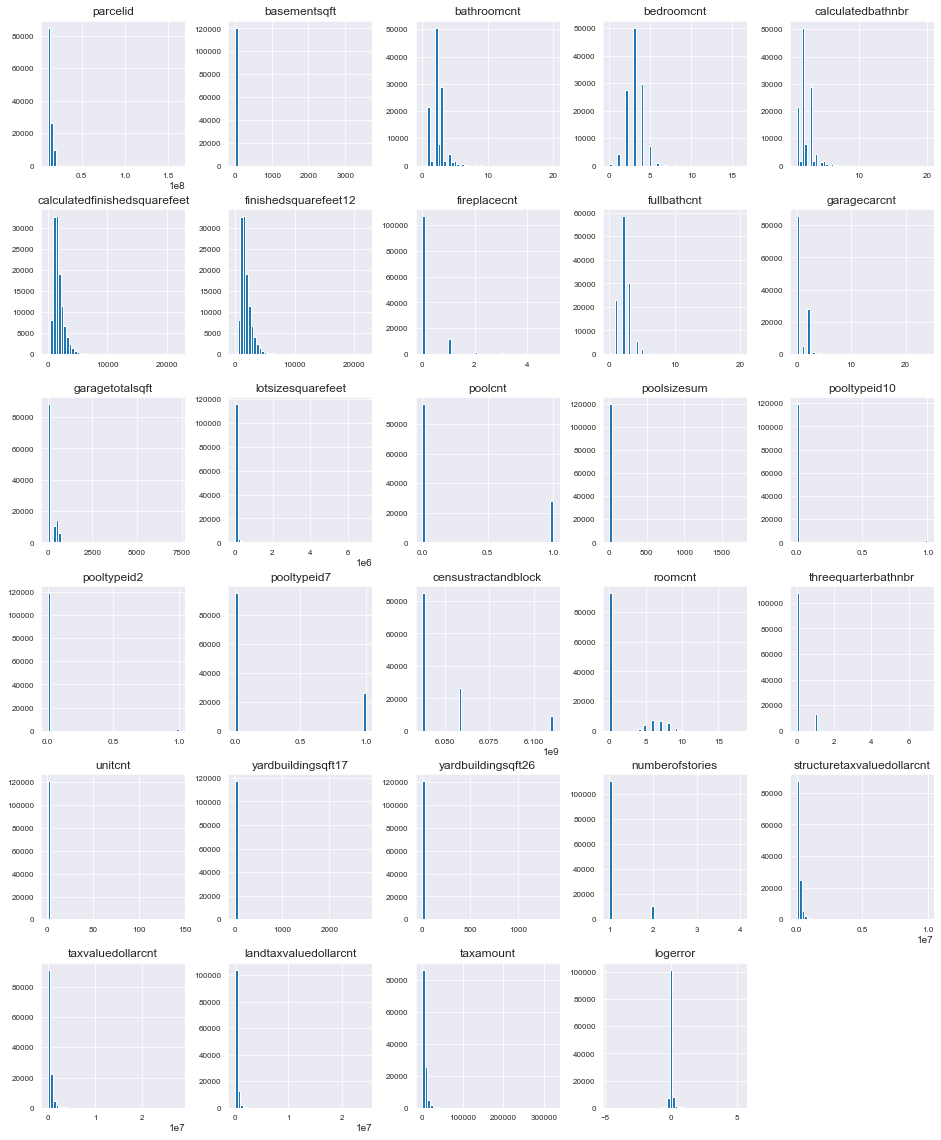

In [84]:
# viewing all numerical categories
df_num = traindf.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

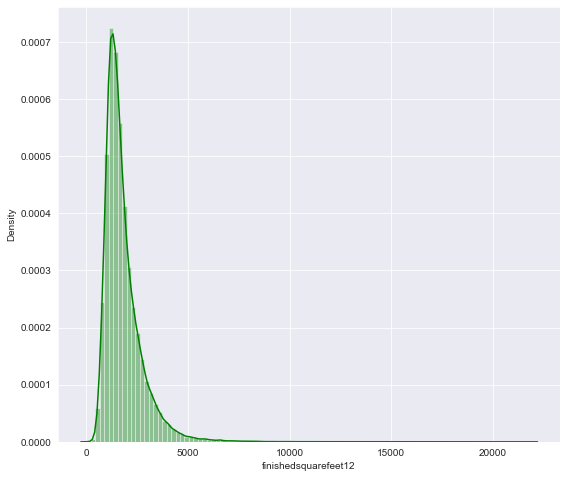

In [85]:
# Histogram for testing of square footage (skewed left)
plt.figure(figsize=(9, 8))
sns.distplot(traindf['finishedsquarefeet12'], color='g', bins=100, hist_kws={'alpha': 0.4});

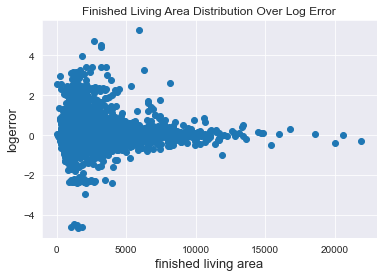

In [86]:
# Distribution of Living Area over Log Error
fig, ax = plt.subplots()
ax.scatter(x = traindf['finishedsquarefeet12'], y = traindf['logerror'])
plt.ylabel('logerror', fontsize=13)
plt.xlabel('finished living area', fontsize=13)
plt.title('Finished Living Area Distribution Over Log Error')
plt.show()

# Exploratory Data Analysis

## Demographics Data

In [87]:
demographics = demographics_data.copy(deep = True)

demographics.head(10)

,Unnamed: 0,censustractandblock,total,hispanic_or_latino,not_hispanic_or_latino,white_alone,black_alone,asian_alone
0,1,1000000US060371011101000,101,28,73,60,2,9
1,2,1000000US060371011101001,81,22,59,39,6,8
2,3,1000000US060371011101002,75,10,65,49,1,7
3,4,1000000US060371011101003,76,25,51,45,0,0
4,5,1000000US060371011101004,155,28,127,108,0,11
5,6,1000000US060371011101005,138,35,103,86,3,7
6,7,1000000US060371011101006,212,36,176,145,0,26
7,8,1000000US060371011101007,388,118,270,209,16,37
8,9,1000000US060371011101008,412,151,261,226,5,21
9,10,1000000US060371011101009,103,12,91,71,0,19


In [88]:
# remove first portion of census number, not relevant
demographics['censustractandblock'] = demographics['censustractandblock'].astype(str).str[10:20]

In [89]:
# aggregate by common census tract (we were told to remove block)
demographics_agg = demographics.groupby('censustractandblock', as_index=False).sum()
demographics_agg.head()

,censustractandblock,Unnamed: 0,total,hispanic_or_latino,not_hispanic_or_latino,white_alone,black_alone,asian_alone
0,6037101110,465,4926,1381,3545,2840,65,434
1,6037101122,1188,3728,542,3186,2614,31,392
2,6037101220,1587,3344,1081,2263,1751,34,352
3,6037101221,855,3444,1178,2266,1840,73,246
4,6037101222,1158,2808,1040,1768,1455,76,148


In [90]:
# calculating percentage white and nonwhite
demographics_agg['censustractandblock'] = demographics_agg['censustractandblock'].astype(float)
demographics_agg['percentwhite'] = demographics_agg['white_alone'] / demographics_agg['total']
demographics_agg['percentnonwhite'] = 1 - demographics_agg['percentwhite']

In [91]:
# merging with main data
df = pd.merge(demographics_agg[['percentwhite', 'percentnonwhite', 'censustractandblock']], traindf, on='censustractandblock') # lean
df_full = pd.merge(demographics_agg, traindf, on='censustractandblock') # full
df_full.drop("Unnamed: 0", axis = 1, inplace = True)

In [92]:
df_full.head()

,censustractandblock,total,hispanic_or_latino,not_hispanic_or_latino,white_alone,black_alone,asian_alone,percentwhite,percentnonwhite,parcelid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,logerror,transactiondate
0,6.037101e+09,4926,1381,3545,2840,65,434,0.576533,0.423467,10996479,...,False,194257.0,500378.0,2015.0,306121.0,6257.23,N,None,0.273100,2016-01-14
1,6.037101e+09,4926,1381,3545,2840,65,434,0.576533,0.423467,11002506,...,False,74923.0,143470.0,2015.0,68547.0,1851.66,Y,14.0,0.004000,2016-07-29
2,6.037101e+09,4926,1381,3545,2840,65,434,0.576533,0.423467,10996762,...,False,60790.0,303953.0,2015.0,243163.0,3783.34,N,None,0.047881,2017-02-06
3,6.037101e+09,4926,1381,3545,2840,65,434,0.576533,0.423467,10996567,...,False,67840.0,99353.0,2015.0,31513.0,1248.70,N,None,-0.107002,2017-04-06
4,6.037101e+09,4926,1381,3545,2840,65,434,0.576533,0.423467,11002141,...,False,146147.0,364298.0,2015.0,218151.0,4543.36,N,None,-0.087700,2016-04-26


In [93]:
df.head()

,percentwhite,percentnonwhite,censustractandblock,parcelid,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,logerror,transactiondate
0,0.576533,0.423467,6.037101e+09,10996479,1.0,0.0,2.0,3.0,7.0,2.0,...,False,194257.0,500378.0,2015.0,306121.0,6257.23,N,None,0.273100,2016-01-14
1,0.576533,0.423467,6.037101e+09,11002506,5.0,0.0,1.0,2.0,7.0,1.0,...,False,74923.0,143470.0,2015.0,68547.0,1851.66,Y,14.0,0.004000,2016-07-29
2,0.576533,0.423467,6.037101e+09,10996762,5.0,0.0,2.0,3.0,7.0,2.0,...,False,60790.0,303953.0,2015.0,243163.0,3783.34,N,None,0.047881,2017-02-06
3,0.576533,0.423467,6.037101e+09,10996567,5.0,0.0,1.0,2.0,7.0,1.0,...,False,67840.0,99353.0,2015.0,31513.0,1248.70,N,None,-0.107002,2017-04-06
4,0.576533,0.423467,6.037101e+09,11002141,5.0,0.0,2.0,2.0,7.0,2.0,...,False,146147.0,364298.0,2015.0,218151.0,4543.36,N,None,-0.087700,2016-04-26


In [94]:
# exporting to csv
df_full.to_csv('./data/traindf_clean_full.csv')
df.to_csv('./data/traindf_clean.csv')
testdf.to_csv('./data/testdf_clean.csv')

## Demographics Analysis


In [95]:
# @title Creating new columns for majority white or not
df['majorityWhite'] = np.where(df['percentwhite'] >= .50, 1, 0)
percwhite = df['percentwhite']
percnonwhite = df['percentnonwhite']
df.drop('percentwhite', axis=1, inplace=True)
df.drop('percentnonwhite', axis=1, inplace=True)

# new dataframe split from original
dfwhite = df[df['majorityWhite'] == 1]
dfnonwhite = df[df['majorityWhite'] == 0]
dfwhite.head()

,censustractandblock,parcelid,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,logerror,transactiondate,majorityWhite
0,6.037101e+09,10996479,1.0,0.0,2.0,3.0,7.0,2.0,0.0,1560.0,...,194257.0,500378.0,2015.0,306121.0,6257.23,N,None,0.273100,2016-01-14,1
1,6.037101e+09,11002506,5.0,0.0,1.0,2.0,7.0,1.0,0.0,1036.0,...,74923.0,143470.0,2015.0,68547.0,1851.66,Y,14.0,0.004000,2016-07-29,1
2,6.037101e+09,10996762,5.0,0.0,2.0,3.0,7.0,2.0,0.0,928.0,...,60790.0,303953.0,2015.0,243163.0,3783.34,N,None,0.047881,2017-02-06,1
3,6.037101e+09,10996567,5.0,0.0,1.0,2.0,7.0,1.0,0.0,1154.0,...,67840.0,99353.0,2015.0,31513.0,1248.70,N,None,-0.107002,2017-04-06,1
4,6.037101e+09,11002141,5.0,0.0,2.0,2.0,7.0,2.0,0.0,1192.0,...,146147.0,364298.0,2015.0,218151.0,4543.36,N,None,-0.087700,2016-04-26,1


In [96]:
# @title Alternate: Create new columns for majority white or majority Black
yoshidf = df_full.copy(deep = True)

yoshidf['percentblack'] = yoshidf['black_alone'] / yoshidf['total']
yoshidf['majoritywhite'] = -99
yoshidf['majorityblack'] = -99

yoshidf['majoritywhite'] = np.where(yoshidf['percentwhite'] >= .50, 1, 0)
yoshidf['majorityblack'] = np.where(yoshidf['percentblack'] >= .50, 1, 0)

yoshidfwhite = yoshidf[yoshidf['majoritywhite'] == 1]
yoshidfblack = yoshidf[yoshidf['majorityblack'] == 1]

In [97]:
# @title White/Nonwhite Dataframe Overviews
print(dfwhite['logerror'].describe())
dfnonwhite['logerror'].describe()

count    41841.000000
mean         0.011515
std          0.157885
min         -2.406257
25%         -0.024300
50%          0.007000
75%          0.040278
max          5.262999
Name: logerror, dtype: float64


count    59164.000000
mean         0.014621
std          0.156554
min         -4.655420
25%         -0.027400
50%          0.004000
75%          0.037300
max          3.443000
Name: logerror, dtype: float64

In [98]:
# @title Alternate: White/Black Dataframe Overviews
print(yoshidfwhite['logerror'].describe())
yoshidfblack['logerror'].describe()

count    41841.000000
mean         0.011515
std          0.157885
min         -2.406257
25%         -0.024300
50%          0.007000
75%          0.040278
max          5.262999
Name: logerror, dtype: float64


count    1176.000000
mean        0.008474
std         0.202334
min        -0.627160
25%        -0.051300
50%        -0.007000
75%         0.034400
max         3.160000
Name: logerror, dtype: float64

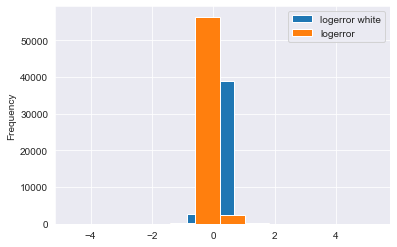

In [99]:
fig1 = dfwhite['logerror'].plot.hist(label='logerror white')
dfnonwhite['logerror'].plot.hist('log error nonwhite')
fig1.legend()

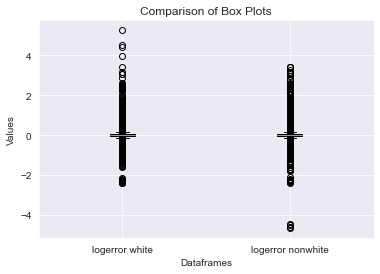

In [100]:
# @title Box Plot Comparison
# Create a figure and axes
fig, ax = plt.subplots()

# Create box plots for the two columns
ax.boxplot([dfwhite['logerror'], dfnonwhite['logerror']], labels=['logerror white', 'logerror nonwhite'])

# Set the title and labels
ax.set_title('Comparison of Box Plots')
ax.set_xlabel('Dataframes')
ax.set_ylabel('Values')

# Show the plot
plt.show()

Text(0.5, 1.0, 'CCDF of log-errors by neighborhood composition')

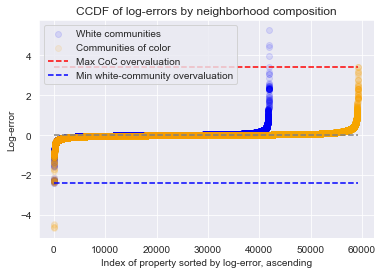

In [101]:
# @title CCDF Comparisons: White v. Nonwhite

white_errors = sorted(dfwhite['logerror'])
coc_errors = sorted(dfnonwhite['logerror'])
plt.xlabel('Index of property sorted by log-error, ascending')
plt.ylabel('Log-error')
plt.scatter(range(len(dfwhite)), white_errors, color = 'blue', alpha = 0.1, label = 'White communities')
plt.scatter(range(len(dfnonwhite)), coc_errors, color = 'orange', alpha = 0.1, label ='Communities of color')
plt.hlines(max(coc_errors), xmin = 0, xmax =len(coc_errors)+100 ,colors = 'r', linestyles = 'dashed', label = 'Max CoC overvaluation')
plt.hlines(min(white_errors), xmin = 0, xmax =len(coc_errors)+100 ,colors = 'b', linestyles = 'dashed', label = 'Min white-community overvaluation')
plt.hlines(0, xmin = 0, xmax = len(coc_errors)+100, colors = 'gray', linestyles = 'dashed')
plt.legend()
plt.title('CCDF of log-errors by neighborhood composition')

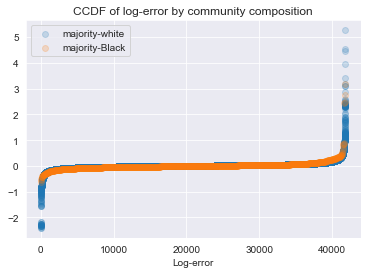

In [102]:
# @title CCDF Comparisons: White v. Black

white_errors = sorted(yoshidfwhite['logerror'])
black_errors = sorted(yoshidfblack['logerror'])
black_indices = [(len(yoshidfwhite)/len(yoshidfblack))*x for x in range(len(yoshidfblack))]

plt.scatter(range(len(yoshidfwhite)), white_errors, label = 'majority-white', alpha = 0.2)
plt.scatter(black_indices, black_errors, label = 'majority-Black', alpha = 0.2)
plt.title('CCDF of log-error by community composition')
plt.xlabel('Log-error')
plt.legend()

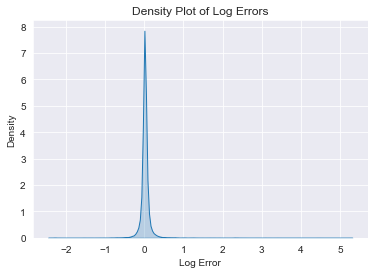

In [103]:
# @title Skew of White Subset
# Assuming your dataframe is named 'dfwhite' and the log error column is 'logerror'
sns.kdeplot(data=dfwhite['logerror'], shade=True)
plt.xlabel('Log Error')
plt.ylabel('Density')
plt.title('Density Plot of Log Errors')
plt.show()

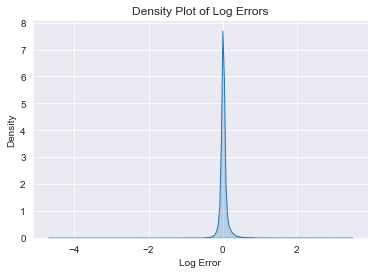

In [104]:
# @title Skew of Nonwhite Subset
sns.kdeplot(data=dfnonwhite['logerror'], shade=True)
plt.xlabel('Log Error')
plt.ylabel('Density')
plt.title('Density Plot of Log Errors')
plt.show()

In [105]:
# Skew values
print("Skew of majority white: ", skew(dfwhite['logerror']))
print("Skew of majority nonwhite: ", skew(dfnonwhite['logerror']))

Skew of majority white:  4.773994254571094
Skew of majority nonwhite:  1.3637110574505753


In [106]:
from scipy import stats

# getting column values
column1_values = dfwhite['logerror']
column2_values = dfnonwhite['logerror']

# Perform t-test
t_statistic, p_value = stats.ttest_ind(column1_values, column2_values)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -3.0947409062915017
P-value: 0.0019703870180517585


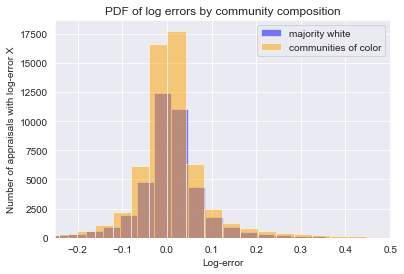

In [107]:
# @title Layered histograms of log-error for properties sold in majority-white versus communities of color
plt.hist(dfwhite['logerror'], color = 'blue', alpha = 0.5, label = 'majority white', bins = 200)
plt.hist(dfnonwhite['logerror'], color = 'orange', alpha = 0.5, label = 'communities of color', bins = 200)
plt.title('PDF of log errors by community composition')
plt.xlabel('Log-error')
plt.ylabel('Number of appraisals with log-error X')
plt.xlim((-0.25, 0.5))
plt.legend()

In [108]:
# @title Compare summary statistics of logerror values for properties sold in majority-white versus communities of color
import scipy
def summary_stats_transform(whitedata, cocdata, blackornonwhite):
    summary_stats = pd.DataFrame(index=['Count', 'Mean', 'Standard Deviation', 'Minimum', '25%', 'Median', '75%', 'Maximum'], columns=['Majority White', 'Communities of Color'])
    for index in range(8):
        summary_stats.iloc[index]['Majority White'] = float(whitedata[index])
        summary_stats.iloc[index]['Communities of Color'] = float(cocdata[index])
    if blackornonwhite == 'black':
        summary_stats = summary_stats.rename({'Communities of Color': 'Majority Black'}, axis = 'columns')
    return(summary_stats)

def summary_stats_transform_times4(whitedata1, cocdata1, whitedata2, cocdata2):
  summary_stats = pd.DataFrame(index=['Count', 'Mean', 'Standard Deviation', 'Minimum', '25%', 'Median', '75%', 'Maximum'], columns=['Overvalued Majority White', 'Overvalued Communities of Color', 'Undervalued Majority White', 'Undervalued Communities of Color'])
  for index in range(8):
    summary_stats.iloc[index]['Overvalued Majority White'] = float(whitedata1[index])
    summary_stats.iloc[index]['Overvalued Communities of Color'] = float(cocdata1[index])
    summary_stats.iloc[index]['Undervalued Majority White'] = float(whitedata2[index])
    summary_stats.iloc[index]['Undervalued Communities of Color'] = float(cocdata2[index])
  return(summary_stats)

def ttest(whitedata, cocdata, label1, label2):
  print('The t-statistic testing the null hypothesis that\n mean log-errors are equal for \n', label1, ' and \n', label2, ' is: ', round(scipy.stats.ttest_ind(whitedata, cocdata, axis = 0, equal_var = False)[0], 5), '\n')
  print('The p-value representing the probability of a Type \nI Error is: ', round(scipy.stats.ttest_ind(whitedata, cocdata, axis = 0, equal_var = False)[1], 5))

ttest(dfwhite['logerror'], dfnonwhite['logerror'], 'majority white communities', 'majority nonwhite communities')
summary_stats_transform(dfwhite['logerror'].describe(), dfnonwhite['logerror'].describe(), 'nonwhite')

The t-statistic testing the null hypothesis that
 mean log-errors are equal for 
 majority white communities  and 
 majority nonwhite communities  is:  -3.09025 

The p-value representing the probability of a Type 
I Error is:  0.002


,Majority White,Communities of Color
Count,41841.0,59164.0
Mean,0.011515,0.014621
Standard Deviation,0.157885,0.156554
Minimum,-2.406257,-4.65542
25%,-0.0243,-0.0274
Median,0.007,0.004
75%,0.040278,0.0373
Maximum,5.262999,3.443


In [109]:
# @title Alternate: Compare summary statistics of log-error values for properties sold in majority-white versus majority-Black neighborhoods

ttest(yoshidfwhite['logerror'], yoshidfblack['logerror'], 'majority white communities', 'majority Black communities')
summary_stats_transform(yoshidfwhite['logerror'].describe(), yoshidfblack['logerror'].describe(), 'black')

The t-statistic testing the null hypothesis that
 mean log-errors are equal for 
 majority white communities  and 
 majority Black communities  is:  0.51096 

The p-value representing the probability of a Type 
I Error is:  0.60947


,Majority White,Majority Black
Count,41841.0,1176.0
Mean,0.011515,0.008474
Standard Deviation,0.157885,0.202334
Minimum,-2.406257,-0.62716
25%,-0.0243,-0.0513
Median,0.007,-0.007
75%,0.040278,0.0344
Maximum,5.262999,3.16


In [110]:
# @title Compare summary statistics of log-error values for properties sold in majority-white versus neighborhoods of color, grouped by undervalued or overvalued

white_over = dfwhite.loc[dfwhite['logerror']>0]
white_under = dfwhite.loc[dfwhite['logerror']<0]
CoC_over = dfnonwhite.loc[dfnonwhite['logerror']>0]
CoC_under = dfnonwhite.loc[dfnonwhite['logerror']<0]

ttest(white_over['logerror'], CoC_over['logerror'], 'overvalued properties in majority white communities', 'overvalued properties in communities of color')
ttest(white_under['logerror'], CoC_under['logerror'], 'undervalued properties in majority white communities', 'undervalued properties in communities of color')
summary_stats_transform_times4(white_over['logerror'].describe(), CoC_over['logerror'].describe(), white_under['logerror'].describe(), CoC_under['logerror'].describe())

The t-statistic testing the null hypothesis that
 mean log-errors are equal for 
 overvalued properties in majority white communities  and 
 overvalued properties in communities of color  is:  -5.10879 

The p-value representing the probability of a Type 
I Error is:  0.0
The t-statistic testing the null hypothesis that
 mean log-errors are equal for 
 undervalued properties in majority white communities  and 
 undervalued properties in communities of color  is:  -5.68184 

The p-value representing the probability of a Type 
I Error is:  0.0


,Overvalued Majority White,Overvalued Communities of Color,Undervalued Majority White,Undervalued Communities of Color
Count,23737.0,31935.0,17879.0,26894.0
Mean,0.069365,0.076194,-0.065145,-0.058313
Standard Deviation,0.155557,0.156565,0.126052,0.122422
Minimum,0.000003,0.000007,-2.406257,-4.65542
25%,0.01528,0.014495,-0.0694,-0.064
Median,0.0344,0.0334,-0.0315,-0.0315
75%,0.0705,0.0742,-0.0131,-0.013866
Maximum,5.262999,3.443,-0.000002,-0.000007


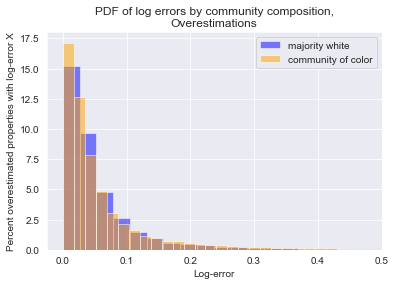

In [111]:
# @title Plot layered histogram for overvalued properties in majority-white versus neighborhoods of color

plt.hist(white_over['logerror'], color = 'blue', alpha = 0.5, label = 'majority white', density = True, bins = 200)
plt.hist(CoC_over['logerror'], color = 'orange', alpha = 0.5, label = 'community of color', density = True, bins = 200)
plt.title('PDF of log errors by community composition,\nOverestimations')
plt.xlabel('Log-error')
plt.ylabel('Percent overestimated properties with log-error X')
plt.xlim((-0.025, 0.5))
plt.legend()

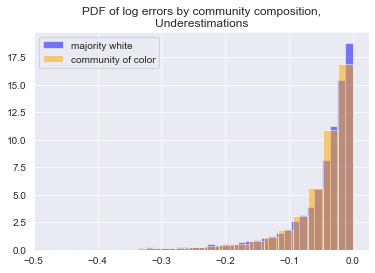

In [112]:
# @title Plot layered histogram for undervalued properties in majority-white versus neighborhoods of color

plt.hist(white_under['logerror'], color = 'blue', alpha = 0.5, label = 'majority white', density = True, bins = 200)
plt.hist(CoC_under['logerror'], color = 'orange', alpha = 0.5, label = 'community of color', density = True, bins = 200)
plt.title('PDF of log errors by community composition,\nUnderestimations')
plt.xlim((-0.5, 0.025))
plt.legend()

[[0.02260238]]
[[0.00101023]]


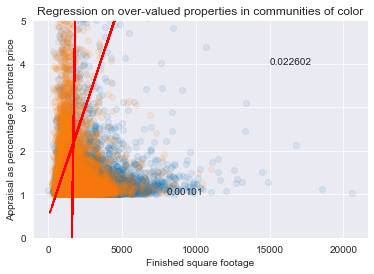

In [113]:
# @title Estimate scaling of increase to appraised value per finished square foot for overvalued properties in majority-white versus communities of color
dfwhite.sort_values('calculatedfinishedsquarefeet', inplace = True)
dfnonwhite.sort_values('calculatedfinishedsquarefeet', inplace = True)

lr1 = sk.linear_model.LinearRegression()
lr1.fit(pd.DataFrame(white_over['calculatedfinishedsquarefeet']), pd.DataFrame(10**white_over['logerror']))
pred_y = lr1.predict(np.array(white_over['calculatedfinishedsquarefeet']).reshape(-1,1))
plt.scatter(white_over['calculatedfinishedsquarefeet'], 10**white_over['logerror'], alpha = 0.1)
plt.plot(white_over['calculatedfinishedsquarefeet'], list(pred_y), color= 'red', linestyle = '--')
plt.annotate(round(float(lr1.coef_), 6), (15000,4))
plt.title('Regression on over-valued properties in white communities')
plt.xlabel('Finished square footage')
plt.ylabel('Appraisal as percentage of contract price')
plt.ylim(0,10)
print(lr1.coef_)

plt.scatter(CoC_over['calculatedfinishedsquarefeet'],10**CoC_over['logerror'], alpha = 0.1)

lr2 = sk.linear_model.LinearRegression()
lr2.fit(pd.DataFrame(CoC_over['calculatedfinishedsquarefeet']), pd.DataFrame(10**CoC_over['logerror']))
pred_y = lr2.predict(np.array(CoC_over['calculatedfinishedsquarefeet']).reshape(-1,1))
plt.plot(CoC_over['calculatedfinishedsquarefeet'], list(pred_y), color= 'red', linestyle = '--')
plt.annotate(round(float(lr2.coef_), 6), (8000,1))
plt.title('Regression on over-valued properties in communities of color')
plt.xlabel('Finished square footage')
plt.ylabel('Appraisal as percentage of contract price')
plt.ylim(0, 5)
print(lr2.coef_)

count    101005.000000
mean       1778.147102
std         928.963650
min           2.000000
25%        1194.000000
50%        1540.000000
75%        2100.000000
max       21929.000000
Name: calculatedfinishedsquarefeet, dtype: float64


(-1.0, 1.0)

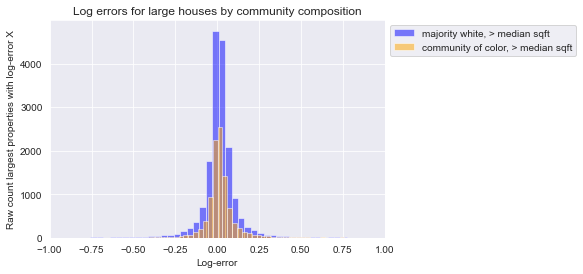

In [114]:
# @title Calculate and visualize log-errors for properties at or above 75th %ile in square footage for properties sold
# in majority-white versus communities of color
print(df.calculatedfinishedsquarefeet.describe())

big_white_houses = dfwhite.loc[dfwhite['calculatedfinishedsquarefeet'] > 2034]
big_CoC_houses = dfnonwhite.loc[dfnonwhite['calculatedfinishedsquarefeet'] > 2034]

plt.hist(big_white_houses['logerror'], color = 'blue', alpha = 0.5, label = 'majority white, > median sqft', bins = 200)
plt.hist(big_CoC_houses['logerror'], color = 'orange', alpha = 0.5, label = 'community of color, > median sqft', bins = 200)
plt.title('Log errors for large houses by community composition')
plt.xlabel('Log-error')
plt.ylabel('Raw count largest properties with log-error X')
plt.legend(bbox_to_anchor = (1,1))
plt.xlim((-1, 1))

In [115]:
# @title Calculate and visualize log-errors for properties at or below 25th %ile in square footage for properties sold
# in majority-white versus communities of color

small_white_houses = dfwhite.loc[dfwhite['calculatedfinishedsquarefeet']<1161]
small_coc_houses = dfnonwhite.loc[dfnonwhite['calculatedfinishedsquarefeet']<1161]

ttest(small_white_houses['logerror'], small_coc_houses['logerror'], 'bottom quartile houses (sqft) in white communities', 'bottom quartiler houses (sqft) in communities of color')
summary_stats_transform(small_white_houses['logerror'].describe(), small_coc_houses['logerror'].describe(), 'nonwhite')

The t-statistic testing the null hypothesis that
 mean log-errors are equal for 
 bottom quartile houses (sqft) in white communities  and 
 bottom quartiler houses (sqft) in communities of color  is:  -0.12768 

The p-value representing the probability of a Type 
I Error is:  0.89841


,Majority White,Communities of Color
Count,5772.0,17155.0
Mean,0.011044,0.011355
Standard Deviation,0.157787,0.167103
Minimum,-2.254,-4.605
25%,-0.0284,-0.0336
Median,0.005,0.002
75%,0.0363,0.0373
Maximum,2.56,3.123634


## Initial Model Attempts
We attempted an aggregation of 3 models in order to predict logerror. But ended up choosing catboost due to accuracy and better handling of categorical data.

In [116]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load your training data and target variable
train_data = traindf
train_id = traindf['parcelid']
train_transac = traindf["transactiondate"]
del traindf['transactiondate']
del traindf['parcelid']
target = train_data['logerror']
features = train_data.drop('logerror', axis=1)

# one-hot encode the categorical features
cat_attribs = ['airconditioningtypeid', 'buildingqualitytypeid', 'decktypeid', 'hashottuborspa',
              'heatingorsystemtypeid', 'propertylandusetypeid', 'propertyzoningdesc', 'regionidcity',
              'regionidcounty', 'regionidneighborhood', 'regionidzip', 'storytypeid', 'typeconstructiontypeid',
              'yearbuilt', 'fireplaceflag', 'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear']
for c in cat_attribs:
    lbl = LabelEncoder()
    lbl.fit(list(features[c].values))
    features[c] = lbl.transform(list(features[c].values))

# split
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.25, random_state=1)

In [117]:
n_folds = 5

def rmsle_cv(model, X, y):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
score = rmsle_cv(lasso, X_train.values, Y_train)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet, X_train.values, Y_train)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

GBoost = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05,
  max_depth=4, max_features='sqrt',
  min_samples_leaf=15, min_samples_split=10,
  loss='huber', random_state=5)
score = rmsle_cv(GBoost, X_train.values, Y_train)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LassoMd = lasso.fit(X_train.values, Y_train)
ENetMd = ENet.fit(X_train.values, Y_train)
GBoostMd = GBoost.fit(X_train.values, Y_train)

combined = (np.expm1(LassoMd.predict(X_test.values)) + np.expm1(ENetMd.predict(X_test.values)) + np.expm1(GBoostMd.predict(X_test.values))) / 3

rmse = np.sqrt(mean_squared_error(Y_test, combined))
print("Root Mean Square Error: %.2f" % rmse)

Lasso score: 0.1566 (0.0087)

ElasticNet score: 0.1566 (0.0087)

Gradient Boosting score: 0.1565 (0.0087)

Root Mean Square Error: 0.16


# Run with CatBoost Model

One model we tested with was the CatBoost Model due to its strong ability to work with categorical data which is highly present in the dataset

## Read in csv and prepare data for model

In [118]:
# Note if running locally this cell is not necessary
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")

%cd /content/drive/MyDrive/Colab \Notebooks/NFHA_Hackathon
%ls

Mounting Failed.
[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Colab \\Notebooks/NFHA_Hackathon'
C:\Qilin\Coding-Projects\NFHA Hackathon
 Volume in drive C is OS
 Volume Serial Number is 86AB-F009

 Directory of C:\Qilin\Coding-Projects\NFHA Hackathon

06/17/2023  10:38 PM    <DIR>          .
06/17/2023  10:38 PM    <DIR>          ..
06/17/2023  09:09 PM    <DIR>          .ipynb_checkpoints
06/16/2023  02:33 AM         1,381,651 2022-01-18-NFHA-et-al_Analysis-of-Appraisal-Standards-and-Appraiser-Criteria_FINAL.pdf
06/17/2023  08:10 PM    <DIR>          catboost_info
06/17/2023  08:54 PM    <DIR>          data
06/17/2023  10:38 PM           510,324 FinalModel.ipynb
06/16/2023  01:58 AM           224,108 how-automated-valuation-models-can-disproportionately-affect-majority-black-neighborhoods_1.pdf
06/16/2023  10:47 AM    <DIR>          kaggle-housing-data
06/17/2023  08:56 PM           560,067 NFHA Inspo.ipynb
06/09/2023  11:14 AM           134,891 prob

In [119]:
# Needed imports
import pandas as pd
import numpy as np

%pip install catboost

import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [120]:
# Read in dataframe and drop first index column
df = pd.read_csv('./data/traindf_clean.csv').iloc[: , 1:]
df

,percentwhite,percentnonwhite,censustractandblock,parcelid,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,logerror,transactiondate
0,0.576533,0.423467,6.037101e+09,10996479,1.0,0.0,2.0,3.0,7.0,2.0,...,False,194257.0,500378.0,2015.0,306121.0,6257.23,N,None,0.273100,2016-01-14
1,0.576533,0.423467,6.037101e+09,11002506,5.0,0.0,1.0,2.0,7.0,1.0,...,False,74923.0,143470.0,2015.0,68547.0,1851.66,Y,14.0,0.004000,2016-07-29
2,0.576533,0.423467,6.037101e+09,10996762,5.0,0.0,2.0,3.0,7.0,2.0,...,False,60790.0,303953.0,2015.0,243163.0,3783.34,N,None,0.047881,2017-02-06
3,0.576533,0.423467,6.037101e+09,10996567,5.0,0.0,1.0,2.0,7.0,1.0,...,False,67840.0,99353.0,2015.0,31513.0,1248.70,N,None,-0.107002,2017-04-06
4,0.576533,0.423467,6.037101e+09,11002141,5.0,0.0,2.0,2.0,7.0,2.0,...,False,146147.0,364298.0,2015.0,218151.0,4543.36,N,None,-0.087700,2016-04-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101000,0.053907,0.946093,6.111009e+09,17162450,5.0,0.0,2.0,4.0,4.0,2.0,...,False,63381.0,90884.0,2015.0,27503.0,1141.68,N,None,0.066267,2017-05-12
101001,0.053907,0.946093,6.111009e+09,17161962,5.0,0.0,2.0,5.0,4.0,2.0,...,False,151700.0,178051.0,2015.0,26351.0,2121.28,N,None,0.040200,2016-03-11
101002,0.053907,0.946093,6.111009e+09,17162426,5.0,0.0,1.0,4.0,4.0,1.0,...,False,64978.0,99954.0,2015.0,34976.0,1251.56,N,None,0.013900,2016-03-21
101003,0.053907,0.946093,6.111009e+09,17162384,5.0,0.0,1.0,4.0,4.0,1.0,...,False,115992.0,231984.0,2015.0,115992.0,2851.06,N,None,-0.030500,2016-08-15


## Data Preparation
We then prepare the cleaned dataset to pass into our model. In order to reduce the number of variables, we drop columns with a high degree of correlation to other ones (for example, pooltypeid2 just describes a subtype of pools), ones with extraordinarly high cardinality, as well as demographic information (as this is not relevenant to feature importance since the original AVM would not have access). We also drop any rows that have NaN present.

In [121]:
df = df.drop(columns=['regionidcity', 'propertylandusetypeid', 'regionidneighborhood', 'regionidzip', 'propertyzoningdesc', 'percentwhite', 'percentnonwhite', 'censustractandblock', 'pooltypeid10','pooltypeid2','pooltypeid7', 'regionidcounty'])
del df['parcelid']
del df['transactiondate']
df = df.dropna()
df

,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,logerror
0,1.0,0.0,2.0,3.0,7.0,2.0,0.0,1560.0,1560.0,0.0,...,1.0,False,194257.0,500378.0,2015.0,306121.0,6257.23,N,None,0.273100
1,5.0,0.0,1.0,2.0,7.0,1.0,0.0,1036.0,1036.0,0.0,...,1.0,False,74923.0,143470.0,2015.0,68547.0,1851.66,Y,14.0,0.004000
2,5.0,0.0,2.0,3.0,7.0,2.0,0.0,928.0,928.0,0.0,...,1.0,False,60790.0,303953.0,2015.0,243163.0,3783.34,N,None,0.047881
3,5.0,0.0,1.0,2.0,7.0,1.0,0.0,1154.0,1154.0,0.0,...,1.0,False,67840.0,99353.0,2015.0,31513.0,1248.70,N,None,-0.107002
4,5.0,0.0,2.0,2.0,7.0,2.0,0.0,1192.0,1192.0,0.0,...,1.0,False,146147.0,364298.0,2015.0,218151.0,4543.36,N,None,-0.087700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101000,5.0,0.0,2.0,4.0,4.0,2.0,0.0,1260.0,1260.0,0.0,...,1.0,False,63381.0,90884.0,2015.0,27503.0,1141.68,N,None,0.066267
101001,5.0,0.0,2.0,5.0,4.0,2.0,0.0,2315.0,2315.0,0.0,...,2.0,False,151700.0,178051.0,2015.0,26351.0,2121.28,N,None,0.040200
101002,5.0,0.0,1.0,4.0,4.0,1.0,0.0,1080.0,1080.0,0.0,...,1.0,False,64978.0,99954.0,2015.0,34976.0,1251.56,N,None,0.013900
101003,5.0,0.0,1.0,4.0,4.0,1.0,0.0,1080.0,1080.0,0.0,...,1.0,False,115992.0,231984.0,2015.0,115992.0,2851.06,N,None,-0.030500


The next block converts all categorical data types to the category type in Pandas. This is necessary for CatBoost to work. Cat_cols also contain all categorical columns in the dataframe.

We will then split the dataframe

In [122]:
from pandas.api.types import is_numeric_dtype

cat_cols = ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt','buildingqualitytypeid','calculatedbathnbr','decktypeid','fireplacecnt','fullbathcnt','garagecarcnt','garagetotalsqft',
               'hashottuborspa','heatingorsystemtypeid', 'poolcnt', 'roomcnt','storytypeid','threequarterbathnbr','typeconstructiontypeid','unitcnt','yearbuilt',
               'numberofstories','fireplaceflag','assessmentyear','taxdelinquencyflag','taxdelinquencyyear']

def convert_cats(X):
  for col in cat_cols:
      if is_numeric_dtype(X[col]) or col == 'heatingorsystemtypeid' or col == 'poolcnt':
        X[col] = X[col].astype('int')
      X[col] = X[col].astype('category')

convert_cats(df)

In [123]:
X = df.loc[:, df.columns != "logerror"]
y = df.loc[:, df.columns == "logerror"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Run the model

We then create datasets and train the model. Model hyperparameters come from a grid search.

In [124]:
train_dataset = cb.Pool(X_train,y_train, cat_features=cat_cols)
test_dataset = cb.Pool(X_test,y_test, cat_features=cat_cols)

In [125]:
catboost_model = cb.CatBoostRegressor(iterations=150, loss_function='RMSE', depth=6, learning_rate=0.1, l2_leaf_reg=1)
catboost_model.fit(train_dataset)

0:	learn: 0.1578669	total: 324ms	remaining: 48.2s
1:	learn: 0.1577671	total: 491ms	remaining: 36.3s
2:	learn: 0.1577014	total: 625ms	remaining: 30.6s
3:	learn: 0.1576301	total: 747ms	remaining: 27.3s
4:	learn: 0.1575527	total: 835ms	remaining: 24.2s
5:	learn: 0.1575121	total: 923ms	remaining: 22.2s
6:	learn: 0.1574814	total: 1.02s	remaining: 20.8s
7:	learn: 0.1574349	total: 1.16s	remaining: 20.5s
8:	learn: 0.1573824	total: 1.28s	remaining: 20.1s
9:	learn: 0.1573252	total: 1.41s	remaining: 19.7s
10:	learn: 0.1572689	total: 1.54s	remaining: 19.4s
11:	learn: 0.1572411	total: 1.67s	remaining: 19.2s
12:	learn: 0.1571424	total: 1.79s	remaining: 18.8s
13:	learn: 0.1570932	total: 1.92s	remaining: 18.7s
14:	learn: 0.1570263	total: 2.05s	remaining: 18.4s
15:	learn: 0.1569390	total: 2.17s	remaining: 18.2s
16:	learn: 0.1569183	total: 2.29s	remaining: 18s
17:	learn: 0.1568806	total: 2.4s	remaining: 17.6s
18:	learn: 0.1568411	total: 2.5s	remaining: 17.2s
19:	learn: 0.1567677	total: 2.59s	remaining: 

Next, we provide evaluation metrics for the model on the validation set.

In [126]:
pred = catboost_model.predict(X_test)

rmse = mean_squared_error(y_test, pred, squared=False)
print(f"RMSE on validation set: {rmse}")

RMSE on validation set: 0.15312192099728508


Text(0.5, 1.0, 'Feature Importance')

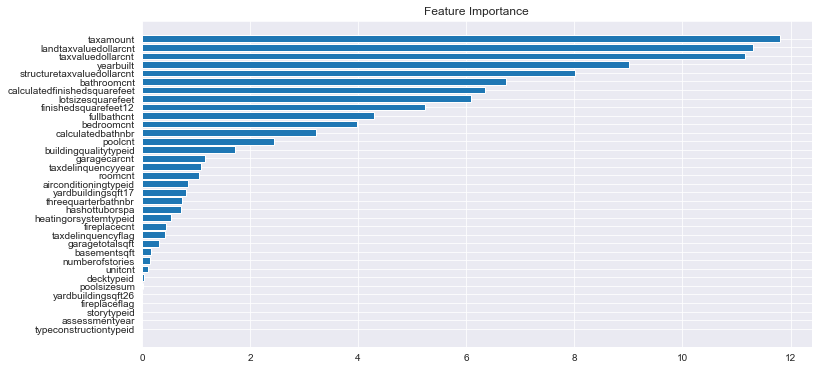

In [127]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'SHAP Importance')

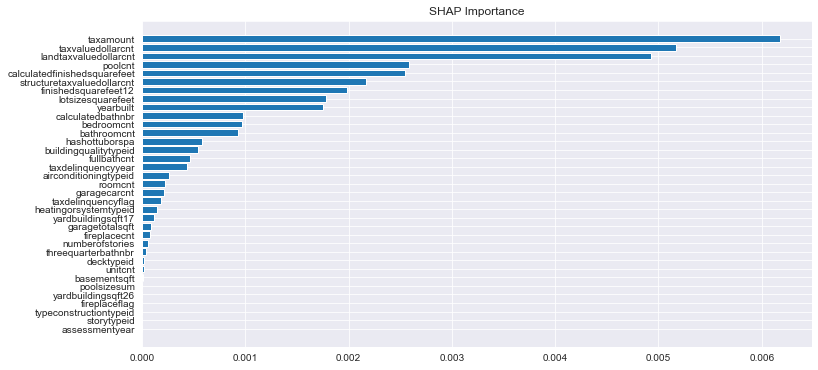

In [128]:
# %pip install shap
import shap
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')

## Running on Test Dataset

In [129]:
# Load your test data and target variable
test_data = pd.read_csv('./data/testdf_clean.csv')
testdf = test_data
test_id = testdf['parcelid']
test_transac = testdf["transactiondate"]
del testdf['transactiondate']
del testdf['parcelid']
target = test_data['logerror']
features = test_data.drop('logerror', axis=1)

# Similar steps as before with regards to dropping columns
features = features.drop(columns=['regionidcity', 'propertylandusetypeid', 'regionidneighborhood', 'regionidzip', 'propertyzoningdesc', 'censustractandblock', 'pooltypeid10','pooltypeid2','pooltypeid7', 'regionidcounty'])
features = features.fillna(0)
features

,Unnamed: 0,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,...,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
0,0,5.0,0.0,2.0,3.0,4.0,2.0,66.0,1444.0,1444.0,...,1951.0,1.0,False,130845.0,436157.0,2016.0,305312.0,5538.80,N,None
1,1,5.0,0.0,1.5,3.0,4.0,1.5,66.0,1698.0,1698.0,...,1979.0,1.0,False,193413.0,286606.0,2016.0,93193.0,2987.36,N,None
2,2,5.0,0.0,1.0,2.0,4.0,1.0,0.0,1170.0,1170.0,...,1948.0,1.0,False,148752.0,592930.0,2016.0,444178.0,6220.70,N,None
3,3,5.0,0.0,2.0,3.0,4.0,2.0,0.0,1257.0,1257.0,...,1930.0,1.0,False,100900.0,462900.0,2016.0,362000.0,4861.56,N,None
4,4,5.0,0.0,2.5,5.0,4.0,2.5,0.0,1718.0,1718.0,...,1964.0,1.0,False,171642.0,286062.0,2016.0,114420.0,3037.60,N,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20551,24207,5.0,0.0,3.5,4.0,4.0,3.5,0.0,2942.0,2942.0,...,2010.0,1.0,False,533617.0,864213.0,2016.0,330596.0,9859.96,N,None
20552,24208,1.0,0.0,3.0,4.0,8.0,3.0,0.0,3661.0,3661.0,...,2006.0,1.0,False,255843.0,319803.0,2016.0,63960.0,6753.55,N,None
20553,24209,1.0,0.0,4.0,5.0,7.0,4.0,0.0,4434.0,4434.0,...,2014.0,1.0,False,320819.0,401023.0,2016.0,80204.0,5546.20,N,None
20554,24211,5.0,0.0,1.0,3.0,5.0,1.0,0.0,792.0,792.0,...,1925.0,1.0,False,44593.0,80605.0,2016.0,36012.0,1074.83,N,None


In [130]:
from pandas.api.types import is_numeric_dtype

cat_cols = ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt','buildingqualitytypeid','calculatedbathnbr','decktypeid','fireplacecnt','fullbathcnt','garagecarcnt','garagetotalsqft',
               'hashottuborspa','heatingorsystemtypeid', 'poolcnt', 'roomcnt','storytypeid','threequarterbathnbr','typeconstructiontypeid','unitcnt','yearbuilt',
               'numberofstories','fireplaceflag','assessmentyear','taxdelinquencyflag','taxdelinquencyyear']

def convert_cats(X):
  for col in cat_cols:
      if is_numeric_dtype(X[col]) or col == 'heatingorsystemtypeid' or col == 'poolcnt':
        X[col] = X[col].astype('int')
      X[col] = X[col].astype('category')

convert_cats(features)

In [131]:
test_dataset = cb.Pool(features,None, cat_features=cat_cols)
testrun = catboost_model.predict(test_dataset)
testrun.shape

(20556,)

In [132]:
submission = pd.DataFrame(index = test_id, data = testrun, columns = ['logerror_Team4']).reset_index()
submission['transactiondate'] = test_transac
submission.to_csv('./submission_test_nick.csv', index=False)

# Testing model with White and Nonwhite Subsets

In [133]:
# compare with white and nonwhite data
dfwhite.head()
dfwhite.to_csv('./data/dfwhite.csv')
white_data = pd.read_csv('./data/dfwhite.csv')

del white_data['parcelid']
del white_data['Unnamed: 0']
del white_data['majorityWhite']
del white_data['transactiondate']
target = white_data['logerror']
features = white_data.drop('logerror', axis=1)

# Similar steps as before with regards to dropping columns
features = features.drop(columns=['regionidcity', 'propertylandusetypeid', 'regionidneighborhood', 'regionidzip', 'propertyzoningdesc', 'censustractandblock', 'pooltypeid10','pooltypeid2','pooltypeid7', 'regionidcounty'])
features = features.fillna(0)
features

,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,...,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
0,5.0,0.0,3.0,0.0,4.0,3.0,0.0,2.0,2.0,0.0,...,1980.0,1.0,False,178681.0,337871.0,2015.0,159190.0,4163.62,N,None
1,5.0,0.0,0.0,0.0,4.0,1.0,0.0,128.0,128.0,0.0,...,1949.0,1.0,False,179.0,49111.0,2015.0,48932.0,849.72,N,None
2,5.0,0.0,1.0,0.0,7.0,1.0,0.0,242.0,242.0,0.0,...,1957.0,1.0,False,57985.0,231952.0,2015.0,173967.0,3059.24,N,None
3,1.0,0.0,1.0,1.0,4.0,1.0,0.0,242.0,242.0,0.0,...,1964.0,1.0,False,12285.0,61445.0,2015.0,49160.0,791.06,N,None
4,5.0,0.0,0.0,0.0,4.0,1.0,0.0,300.0,300.0,0.0,...,1970.0,1.0,False,2018.0,45652.0,2015.0,43634.0,7278.82,N,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41836,1.0,0.0,9.0,8.0,4.0,9.0,0.0,16814.0,16814.0,0.0,...,2010.0,1.0,False,7682031.0,9357555.0,2015.0,1675524.0,114302.94,N,None
41837,1.0,0.0,10.0,6.0,4.0,10.0,0.0,18577.0,18577.0,0.0,...,1991.0,1.0,False,6076315.0,9199204.0,2015.0,3122889.0,109050.78,N,None
41838,1.0,0.0,15.0,7.0,4.0,15.0,0.0,20013.0,20013.0,0.0,...,2000.0,1.0,False,5355639.0,22411718.0,2015.0,17056079.0,272407.03,N,None
41839,1.0,0.0,13.0,7.0,4.0,13.0,0.0,20612.0,20612.0,0.0,...,1994.0,1.0,False,9027236.0,12200809.0,2015.0,3173573.0,149026.60,N,None


In [134]:
from pandas.api.types import is_numeric_dtype

cat_cols = ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt','buildingqualitytypeid','calculatedbathnbr','decktypeid','fireplacecnt','fullbathcnt','garagecarcnt','garagetotalsqft',
               'hashottuborspa','heatingorsystemtypeid', 'poolcnt', 'roomcnt','storytypeid','threequarterbathnbr','typeconstructiontypeid','unitcnt','yearbuilt',
               'numberofstories','fireplaceflag','assessmentyear','taxdelinquencyflag','taxdelinquencyyear']

def convert_cats(X):
  for col in cat_cols:
      if is_numeric_dtype(X[col]) or col == 'heatingorsystemtypeid' or col == 'poolcnt' or col == 'airconditioningtypeid':
        X[col] = X[col].astype('int')
      X[col] = X[col].astype('category')

convert_cats(features)

In [135]:
white_dataset = cb.Pool(features,None, cat_features=cat_cols)
white = catboost_model.predict(white_dataset)
stats.describe(white)

DescribeResult(nobs=41841, minmax=(-0.3149840595744592, 2.505191494011441), mean=0.012674890489120865, variance=0.0005772522535625851, skewness=41.089630458997675, kurtosis=3499.0983468685927)

In [136]:
# compare with white and nonwhite data
dfnonwhite.head()
dfnonwhite.to_csv('./data/dfnonwhite.csv')
nonwhite_data = pd.read_csv('./data/dfnonwhite.csv')

del nonwhite_data['parcelid']
del nonwhite_data['Unnamed: 0']
del nonwhite_data['majorityWhite']
del nonwhite_data['transactiondate']
target = nonwhite_data['logerror']
features = nonwhite_data.drop('logerror', axis=1)

# Similar steps as before with regards to dropping columns
features = features.drop(columns=['regionidcity', 'propertylandusetypeid', 'regionidneighborhood', 'regionidzip', 'propertyzoningdesc', 'censustractandblock', 'pooltypeid10','pooltypeid2','pooltypeid7', 'regionidcounty'])
features = features.fillna(0)
features

,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,...,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
0,1.0,0.0,20.0,3.0,7.0,20.0,0.0,66.0,66.0,0.0,...,1960.0,1.0,False,165069.0,233496.0,2015.0,68427.0,2831.76,N,None
1,5.0,0.0,0.0,1.0,4.0,1.0,0.0,120.0,120.0,0.0,...,1955.0,1.0,False,113.0,9271.0,2015.0,9158.0,244.11,N,None
2,5.0,0.0,2.0,3.0,7.0,2.0,0.0,152.0,152.0,0.0,...,1939.0,1.0,False,67402.0,85122.0,2015.0,17720.0,1565.27,N,None
3,5.0,0.0,0.0,0.0,4.0,1.0,0.0,160.0,160.0,0.0,...,1922.0,1.0,False,1000.0,105000.0,2015.0,104000.0,1354.62,Y,15.0
4,5.0,0.0,1.0,0.0,7.0,1.0,0.0,199.0,199.0,0.0,...,1928.0,1.0,False,35670.0,102553.0,2015.0,66883.0,1358.83,Y,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59159,1.0,0.0,8.0,7.0,10.0,8.0,0.0,8391.0,8391.0,0.0,...,1998.0,1.0,False,1407410.0,2179853.0,2015.0,772443.0,25043.80,N,None
59160,1.0,0.0,7.0,6.0,8.0,7.0,0.0,8586.0,8586.0,0.0,...,2012.0,1.0,False,1787004.0,4467511.0,2015.0,2680507.0,50636.14,N,None
59161,1.0,0.0,6.0,6.0,10.0,6.0,0.0,10132.0,10132.0,0.0,...,2004.0,1.0,False,1980189.0,3059939.0,2015.0,1079750.0,34869.45,N,None
59162,1.0,0.0,9.0,6.0,10.0,9.0,0.0,10417.0,10417.0,0.0,...,2003.0,1.0,False,2417536.0,3222090.0,2015.0,804554.0,36669.49,N,None


In [137]:
from pandas.api.types import is_numeric_dtype

cat_cols = ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt','buildingqualitytypeid','calculatedbathnbr','decktypeid','fireplacecnt','fullbathcnt','garagecarcnt','garagetotalsqft',
               'hashottuborspa','heatingorsystemtypeid', 'poolcnt', 'roomcnt','storytypeid','threequarterbathnbr','typeconstructiontypeid','unitcnt','yearbuilt',
               'numberofstories','fireplaceflag','assessmentyear','taxdelinquencyflag','taxdelinquencyyear']

def convert_cats(X):
  for col in cat_cols:
      if is_numeric_dtype(X[col]) or col == 'heatingorsystemtypeid' or col == 'poolcnt' or col == 'airconditioningtypeid':
        X[col] = X[col].astype('int')
      X[col] = X[col].astype('category')

convert_cats(features)

In [138]:
nonwhite_dataset = cb.Pool(features,None, cat_features=cat_cols)
nonwhite = catboost_model.predict(nonwhite_dataset)
stats.describe(nonwhite)

DescribeResult(nobs=59164, minmax=(-0.3718207196066792, 0.5684118400276208), mean=0.012867235531364386, variance=0.00021162925935628118, skewness=4.101000239558061, kurtosis=154.77241697097182)